
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Google ドライブをマウント

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!ls drive/My\ Drive

In [2]:
import os
!ls drive
print(os.getcwd())
os.chdir("drive/My Drive/data/facial_pose")
print(os.getcwd())

'My Drive'
/content
/content/drive/My Drive/data/facial_pose


In [3]:
!ls

faces


# PyTorchをイントール

In [4]:
!pip install torch torchvision

  Using cached https://files.pythonhosted.org/packages/92/e3/217dfd0834a51418c602c96b110059c477260c7fee898542b100913947cf/Pillow-5.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [6]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.0
    Uninstalling Pillow-5.4.0:
      Successfully uninstalled Pillow-5.4.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
from PIL import Image
%matplotlib inline

Dataset comes with a csv file with annotations which looks like this:  
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y  
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

In [8]:
gt_path = os.path.join("faces","face_landmarks.csv")
landmaarks_frame = pd.read_csv(gt_path)

n = 65
img_name = landmaarks_frame.iloc[n, 0]
print(img_name)
print()

landmarks = landmaarks_frame.iloc[n, 1:].as_matrix() # as_matrix()でデータフレームをリストに変換する
print(landmarks.shape)
print(landmarks)
print()

landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

person-7.jpg

(136,)
[32 65 33 76 34 86 34 97 37 107 41 116 50 122 61 126 72 127 83 126 95 123
 107 119 115 111 118 101 120 91 122 80 122 68 39 52 45 46 53 44 61 46 68
 49 82 49 90 45 98 44 106 46 112 52 74 57 74 63 74 69 74 75 67 83 70 84 74
 85 78 84 82 83 47 61 51 57 58 57 63 61 57 63 51 63 87 62 93 58 98 58 103
 61 99 63 93 63 55 98 63 96 70 94 75 95 80 94 86 95 94 99 86 103 79 105 74
 105 69 105 62 103 58 99 70 98 74 98 79 98 91 99 79 99 74 99 69 99]

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


img exists :  faces/person-7.jpg


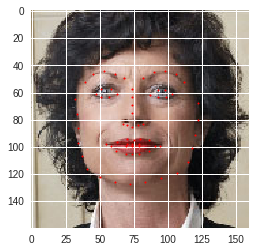

In [9]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    #plt.axis("off")
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated


    
img_path = os.path.join('faces', img_name)

if not os.path.exists(img_path):
    print("img not found : ", img_path)
else:
    print("img exists : ", img_path)

pil_img = Image.open(img_path)

plt.figure()
show_landmarks(pil_img, landmarks)
plt.show()

# DATASET CLASS
torch.utils.data.Datasetはデータセットを表現する抽象クラスである。オリジナルのデータセットを作るときは、torch.utils.data.Datasetを継承する必要がある。  
また以下の2つのメソッドをオーバーライドする必要がある。  

-  **\__len\__ **so that len(dataset) returns the size of the dataset.  
- ** \__getitem\__** to support the indexing such that dataset[i] can be used to get ith sample

In [0]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
                csv_file (string) : Path to the csv file with annotations.
                root_dir (string): Directory with all the images.
                transform(callable, optional): Optional transform to be applied on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix() # fname以外をリストで取得
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

データセットのインスタンスを生成し、最初の4サンプルを表示する。

0 (324, 215, 3) (68, 2)


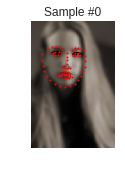

1 (500, 333, 3) (68, 2)


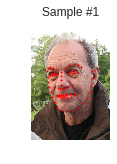

2 (250, 258, 3) (68, 2)


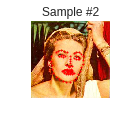

3 (434, 290, 3) (68, 2)


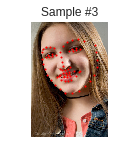

In [11]:
face_dataset = FaceLandmarksDataset(csv_file='./faces/face_landmarks.csv',  root_dir='./faces/')
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

# TRANSFORMS

データセットの画像サイズが異なるため、これを揃える前処理を追加する。  
追加する前処理は以下の3つ
- Rescale: to scale the image
- RandomCrop: to crop from image randomly. This is data augmentation.
- ToTensor: to convert the numpy images to torch images (we need to swap axes).

呼び出し可能なクラスとして渡すことで、毎回パラメータを設定する必要をなくす。  
よって、クラスは\__call\__メソッドと、必要であれば\__init\__メソッドを実装する必要がある。  


---
注意

**numpy imageは「H x W x C」になっているので、Tenosrに変換するときは、「C x H x W」に変換してからTensor型にする。 **

In [0]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image' : img, 'landmarks': landmarks}
    

In [0]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because
        # numpy image : H x W x C
        # torch   image : C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                     'landmarks': torch.from_numpy(landmarks)}

# Compose transforms
サンプルにtransformsを適用する。  

- 画像の短い方の辺を256にリサイズする。
- そのあとランダムに224x224にクロップする。

Rescale


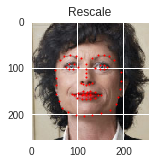

RandomCrop


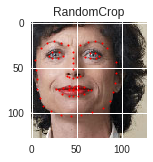

Compose


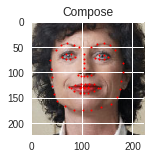

In [15]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                                                             RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    print(type(tsfrm).__name__)
    
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
    
plt.show()

# ITERATING THROUGH THE DATASET

In [16]:

transformed_dataset = FaceLandmarksDataset(csv_file='./faces/face_landmarks.csv',
                                                                                    root_dir='./faces/',
                                                                                    transform=transforms.Compose([
                                                                                        Rescale(256),
                                                                                        RandomCrop(224),
                                                                                        ToTensor()
                                                                                    ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['landmarks'].size())
    
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


以下機能を追加するためにtorch.utils.data.DataLoaderを使用する。  

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.



0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
4 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


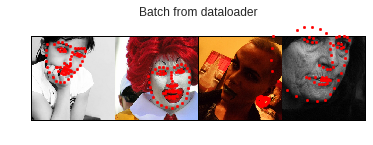

In [17]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                                            shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                           landmarks_batch[i, :, 1].numpy(),
                           s=30, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break